# Image segmentation

In this project, we'll perform semantic segmentation on the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) using PyTorch. We'll utilize the pre-trained [DeepLabV3](https://pytorch.org/vision/main/models/deeplabv3.html) model with a ResNet-50 backbone and adapt it to our specific task. We'll cover data preprocessing, model loading, training, evaluation, and visualization, providing explanations at each step.  
  
Image segmentation is a computer vision technique that involves partitioning an image into distinct regions or segments, where each pixel is assigned to a specific class or object. It provides pixel-level classification, meaning each pixel in the image is labeled as belonging to a particular object or background (e.g., classifying each pixel as "cat," "dog," or "background"). Image segmentation can be classified into two types:

- **Semantic segmentation**: Assigns a class label (e.g., car, road, sky) to every pixel in the image.
- **Instance segmentation**: Differentiates between different instances of the same object class (e.g., identifying two different cars).  

In this notebook, we only deal with semantic segmentation.

##  1. Data Preprocessing and Visualization

Before training the model, we need to load and preprocess the dataset. We'll also visualize some images and their corresponding masks to understand how the labels and masks are composed.

### 1.1 Loading the Oxford-IIIT Pet Dataset

The Oxford-IIIT Pet Dataset is a popular dataset in computer vision, containing images of 37 different breeds of cats and dogs, with approximately 200 images per breed. Each image has an associated mask that labels the pixels corresponding to the pet, background, and pet boundary.

- Input Transformations: We resize the images to 224x224 pixels, convert them to tensors, and normalize them using ImageNet's mean and standard deviation since the pre-trained model was trained on ImageNet.
- Target Transformations: We resize the masks to 224x224 pixels and convert them to tensors.
- Dataset Loading: We load the dataset and split it into training and validation sets.
- Data Loaders: We create data loaders for batching and shuffling.

In [2]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import os

# Define transformations for input images and target masks
input_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet std
])

def target_transform(mask):
    mask = mask.resize((224, 224), Image.NEAREST)
    mask = np.array(mask)
    # Subtract 1 to map mask values from [1,2,3] to [0,1,2]
    mask = mask - 1
    mask = torch.from_numpy(mask).long()
    return mask

# Load the Oxford-IIIT Pet dataset
dataset = OxfordIIITPet(root='./data', split='trainval', target_types='segmentation',
                        transform=input_transform, target_transform=target_transform, download=True)

# Use only the first 1000 images
subset_indices = list(range(1000))
subset_dataset = Subset(dataset, subset_indices)

# Split the subset into training, validation, and test sets
train_size = 700
val_size = 100
test_size = 200

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    subset_dataset, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)

# Create data loaders
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)


Labels and Masks Composition:

- Images: RGB images of cats and dogs.
- Masks: Each pixel in the mask has a value indicating its class:
    - 0: Background
    - 1: Foreground (Pet)
    - 2: Border (Outline of the pet)  
    
Total Classes: 3 (Background, Pet, Border)

In [2]:
print('Number of training images:', len(train_dataset))
print('Number of validation images:', len(val_dataset))
print('Number of testing images:', len(test_dataset))
print()


# Print the shape of the input image and target mask
img, mask = dataset[0]
print('Image shape:', img.shape)
print('Mask shape:', mask.shape)
print('Mask unique values:', torch.unique(mask))

Number of training images: 700
Number of validation images: 100
Number of testing images: 200

Image shape: torch.Size([3, 224, 224])
Mask shape: torch.Size([224, 224])
Mask unique values: tensor([0, 1, 2])


### 1.2 Visualizing images and masks

Here we want to display some random images and their corresponding masks to have an idea of what it looks like.  
  
We use a decode_segmap function to convert the mask to an RGB image for easy visualization.

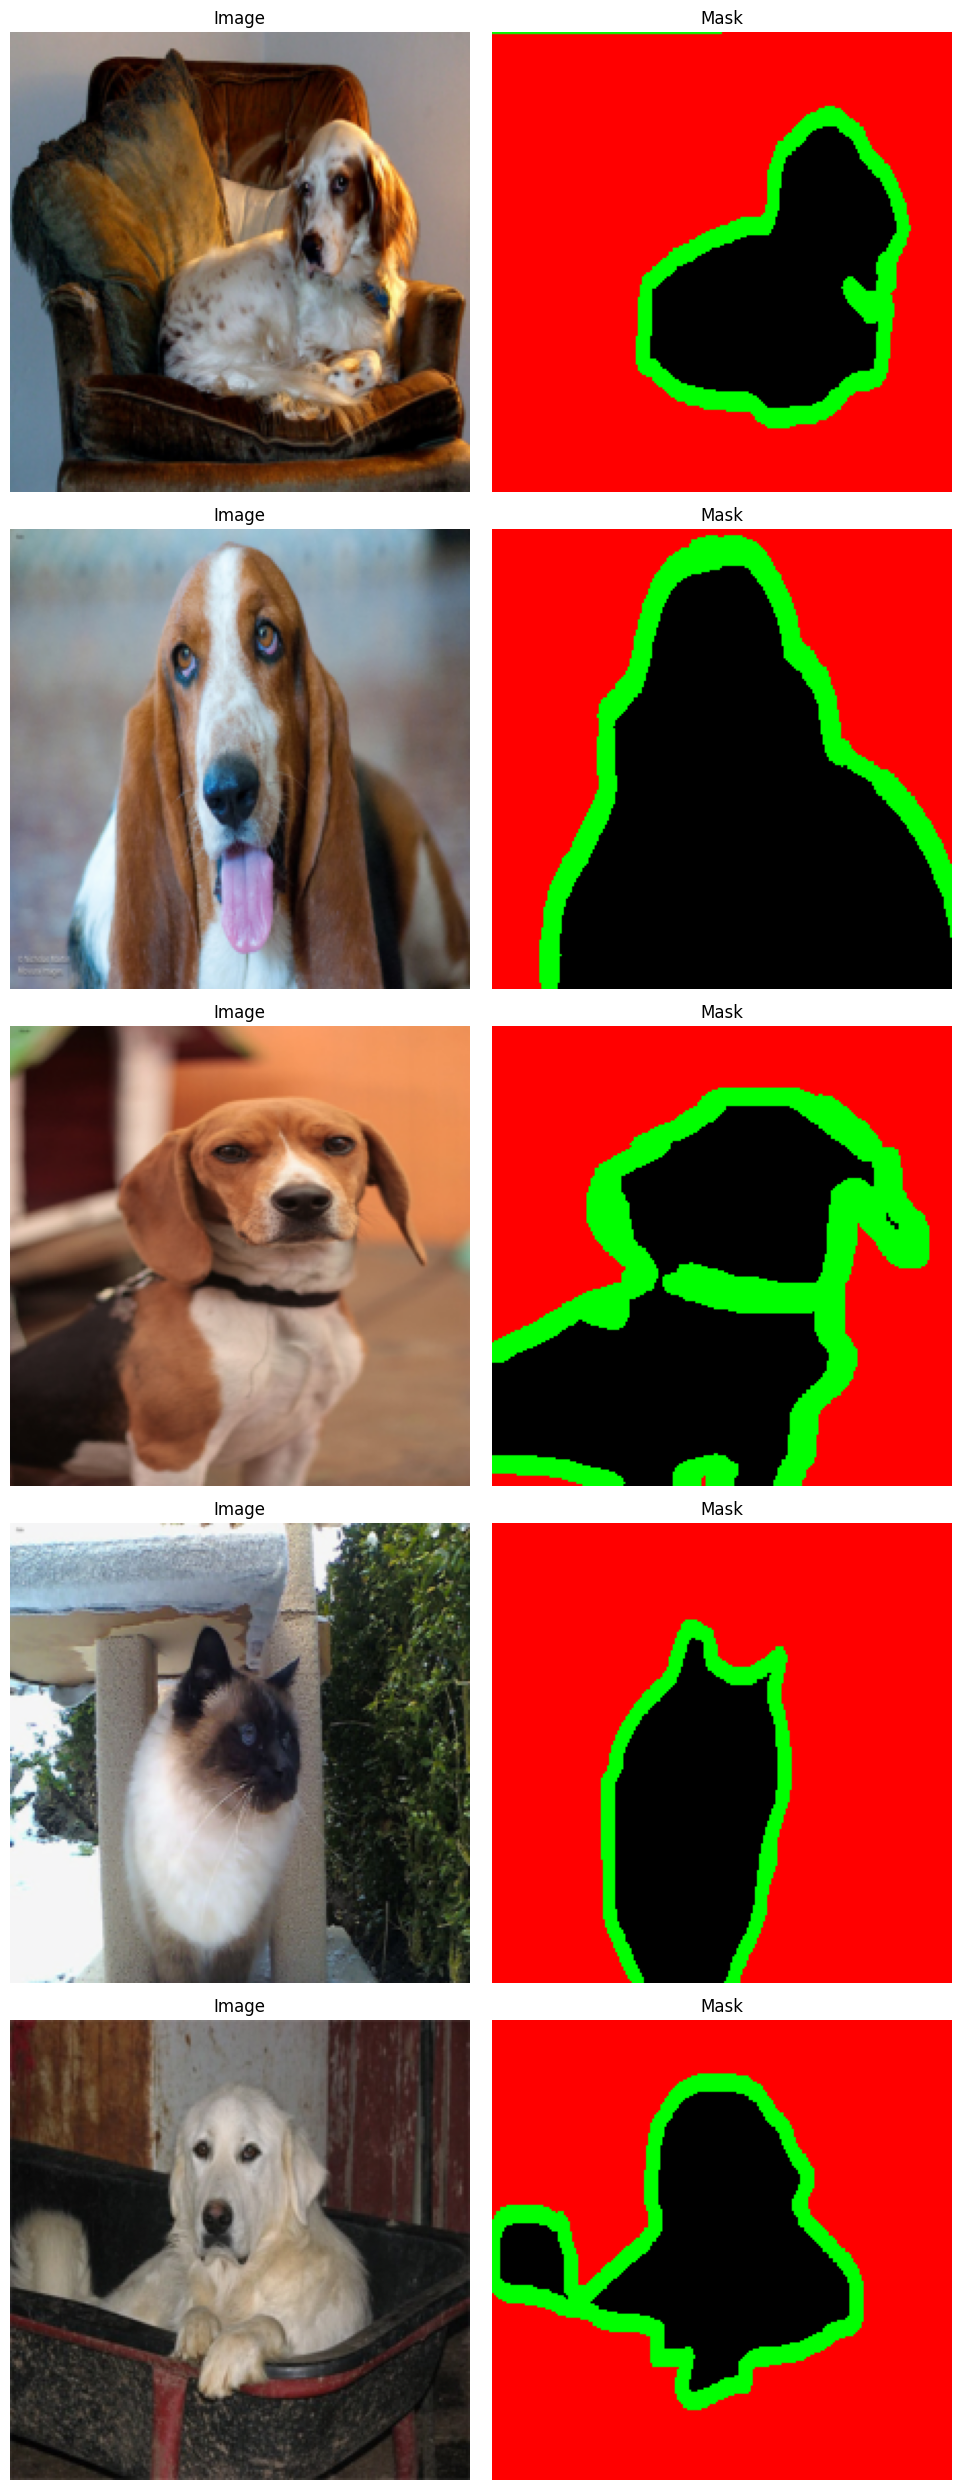

In [3]:
# Converts the mask to an RGB image using a predefined color map for visualization.
def decode_segmap(mask):
    # Define a color map for visualization
    label_colors = np.array([
        (0, 0, 0),       # Background - Black
        (255, 0, 0),     # Pet - Red
        (0, 255, 0)      # Border - Green
    ])
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)
    for l in range(0, 3):
        idx = mask == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb

def visualize_samples(dataset, num_samples=5):
    indices = random.sample(range(len(dataset)), num_samples)
    fig, axs = plt.subplots(num_samples, 2, figsize=(10, num_samples * 5))
    for i, idx in enumerate(indices):
        img, mask = dataset[idx]
        img_np = img.permute(1, 2, 0).numpy()
        img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_np = np.clip(img_np, 0, 1)
        mask_np = mask.numpy()
        mask_rgb = decode_segmap(mask_np)
        
        axs[i, 0].imshow(img_np)
        axs[i, 0].set_title('Image')
        axs[i, 0].axis('off')
        axs[i, 1].imshow(mask_rgb)
        axs[i, 1].set_title('Mask')
        axs[i, 1].axis('off')
    plt.tight_layout()
    plt.show()

# Visualize samples from the training dataset
visualize_samples(train_dataset)

## 2. Model loading

Let's load the pre-trained [DeepLabV3](https://pytorch.org/vision/main/models/deeplabv3.html) with a ResNet-50 backbone model and adapt it to our segmentation task.  

The DeepLabV3 model is a deep learning model designed for semantic segmentation. Developed by Google, it uses atrous (dilated) convolutions to capture multi-scale contextual information, making it effective at segmenting objects with varying scales and complex boundaries.

### 2.1 Load the pretrained model

This PyTorch has been pretrained on a subset of [COCO](https://cocodataset.org/#home), using only the 20 categories that are present in the [Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/) dataset.

In [3]:
from torchvision import models

# Load the pre-trained DeepLabV3 model
model = models.segmentation.deeplabv3_resnet50(weights=models.segmentation.DeepLabV3_ResNet50_Weights.COCO_WITH_VOC_LABELS_V1, pretrained=True)

# Move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)
print(model)

cuda
DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample

Model Components:

- Backbone (ResNet-50): Extracts features from the input images.
- ASPP (Atrous Spatial Pyramid Pooling): Captures multi-scale context using dilated convolutions.
- Classifier: Outputs a segmentation map with the desired number of classes.

### 2.2 Adapt the model to our classes

The pre-trained model's classifier is set up to output segmentation maps for 21 classes (as in the COCO or Pascal VOC datasets). However, our task requires segmenting into 3 classes (Background, Pet, Border). Therefore, we need to modify the last convolutional layer of the classifier to output the correct number of classes.  
  
By changing the number of output channels in the last convolutional layer to match the number of classes (3 in our case), we ensure that the model produces segmentation maps with the correct number of class predictions for each pixel.  

In [22]:
# Modify the classifier to output 3 classes
num_classes = 3  # Background, Pet, Border
model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=1)
model = model.to(device)

In [23]:
print(model.classifier)

DeepLabHead(
  (0): ASPP(
    (convs): ModuleList(
      (0): Sequential(
        (0): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): ASPPConv(
        (0): Conv2d(2048, 256, kernel_size=(3, 3), stride=(1, 1), padding=(12, 12), dilation=(12, 12), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): ASPPConv(
        (0): Conv2d(2048, 256, kernel_size=(3, 3), stride=(1, 1), padding=(24, 24), dilation=(24, 24), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (3): ASPPConv(
        (0): Conv2d(2048, 256, kernel_size=(3, 3), stride=(1, 1), padding=(36, 36), dilation=(36, 36), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_

## 3. Train the model

Set up the training loop, define the loss function, optimizer, and train the model.  
  
An LR scheduler is used to automatically adapt the learning rate (Reduces the learning rate by a factor of gamma every n epochs.).  
  
Be patient, it took me 15 minutes to train 5 epochs on my laptop GPU ^^', but it's enough to get good results.

In [24]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Suitable for multi-class segmentation
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 5
best_val_loss = float('inf')

# Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Training and validation functions with progress printing
def train_one_epoch(model, loader, optimizer, criterion, epoch):
    model.train()
    running_loss = 0.0
    total_batches = len(loader)
    for batch_idx, (images, masks) in enumerate(loader):
        
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)['out']
      
        loss = criterion(outputs, masks)
    
        loss.backward()

        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        if batch_idx % 10 == 0:
            # Print progress
            print(f"Epoch [{epoch+1}], Batch [{batch_idx+1}/{total_batches}], Loss: {loss.item():.4f}")
    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)
            
            outputs = model(images)['out']
            loss = criterion(outputs, masks)
            
            running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss

# Training loop with progress printin

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, epoch)
    val_loss = validate(model, val_loader, criterion)
    scheduler.step()
    
    print(f"Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")
    
    # Save the model if validation loss decreases
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f'best_model_{num_epochs}_epochs.pth')
        print("Model saved!")



Epoch 1/5
Epoch [1], Batch [1/175], Loss: 1.2003
Epoch [1], Batch [11/175], Loss: 0.8067
Epoch [1], Batch [21/175], Loss: 0.7002
Epoch [1], Batch [31/175], Loss: 0.4679
Epoch [1], Batch [41/175], Loss: 0.4252
Epoch [1], Batch [51/175], Loss: 0.3220
Epoch [1], Batch [61/175], Loss: 0.3103
Epoch [1], Batch [71/175], Loss: 0.3045
Epoch [1], Batch [81/175], Loss: 0.3081
Epoch [1], Batch [91/175], Loss: 0.2788
Epoch [1], Batch [101/175], Loss: 0.2758
Epoch [1], Batch [111/175], Loss: 0.3122
Epoch [1], Batch [121/175], Loss: 0.3044
Epoch [1], Batch [131/175], Loss: 0.3411
Epoch [1], Batch [141/175], Loss: 0.3153
Epoch [1], Batch [151/175], Loss: 0.3521
Epoch [1], Batch [161/175], Loss: 0.2378
Epoch [1], Batch [171/175], Loss: 0.2568
Training Loss: 0.4117, Validation Loss: 0.2503
Model saved!

Epoch 2/5
Epoch [2], Batch [1/175], Loss: 0.1991
Epoch [2], Batch [11/175], Loss: 0.2210
Epoch [2], Batch [21/175], Loss: 0.2100
Epoch [2], Batch [31/175], Loss: 0.2516
Epoch [2], Batch [41/175], Loss:

## 4. Model Evaluation

### 4.1 Calculate the Mean IoU

Metric Used: Mean Intersection over Union (mIoU)

- Intersection over Union (IoU): Measures the overlap between the predicted segmentation and the ground truth for each class.
- Mean IoU: Average IoU over all classes.

In [25]:
def calculate_miou(preds, labels, num_classes=3):
    preds = torch.argmax(preds, dim=1).cpu().numpy()
    labels = labels.cpu().numpy()
    ious = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        label_inds = (labels == cls)
        intersection = np.logical_and(pred_inds, label_inds).sum()
        union = np.logical_or(pred_inds, label_inds).sum()
        if union == 0:
            ious.append(float('nan'))  # Ignore if no ground truth for this class
        else:
            ious.append(intersection / union)
    return np.nanmean(ious)


### 4.2 Evaluate the model on the test set

Now let's evaluate the model on the test set.  
  
We use the mIoU metric which provides an overall measure of the model's performance across all classes by measuring for each class the overlap between the predicted segmentation and the ground truth.  
We also measure the mean inference time for each image.

In [26]:
# Load the best model
model.load_state_dict(torch.load(f'best_model_{num_epochs}_epochs.pth'))
model.eval()

miou_scores = []
inference_times = []

with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        # Measure inference time
        start_time = time.time()
        outputs = model(images)['out']
        end_time = time.time()
        inference_times.append(end_time - start_time)
        
        miou = calculate_miou(outputs, masks)
        miou_scores.append(miou)

mean_miou = np.nanmean(miou_scores)
mean_inference_time = np.mean(inference_times) / batch_size  # Time per image

print(f"\nMean mIoU on Test Set: {mean_miou:.4f}")
print(f"Mean Inference Time per Image: {mean_inference_time:.4f} seconds")


C:\Users\33650\AppData\Local\Temp\ipykernel_54664\2334311444.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_model_{num_epochs}_e


Mean mIoU on Test Set: 0.7806
Mean Inference Time per Image: 0.0046 seconds


### 4.3 Visualize predictions

Let's visualize 5 random predictions from the test set to qualitatively assess the model's performance.

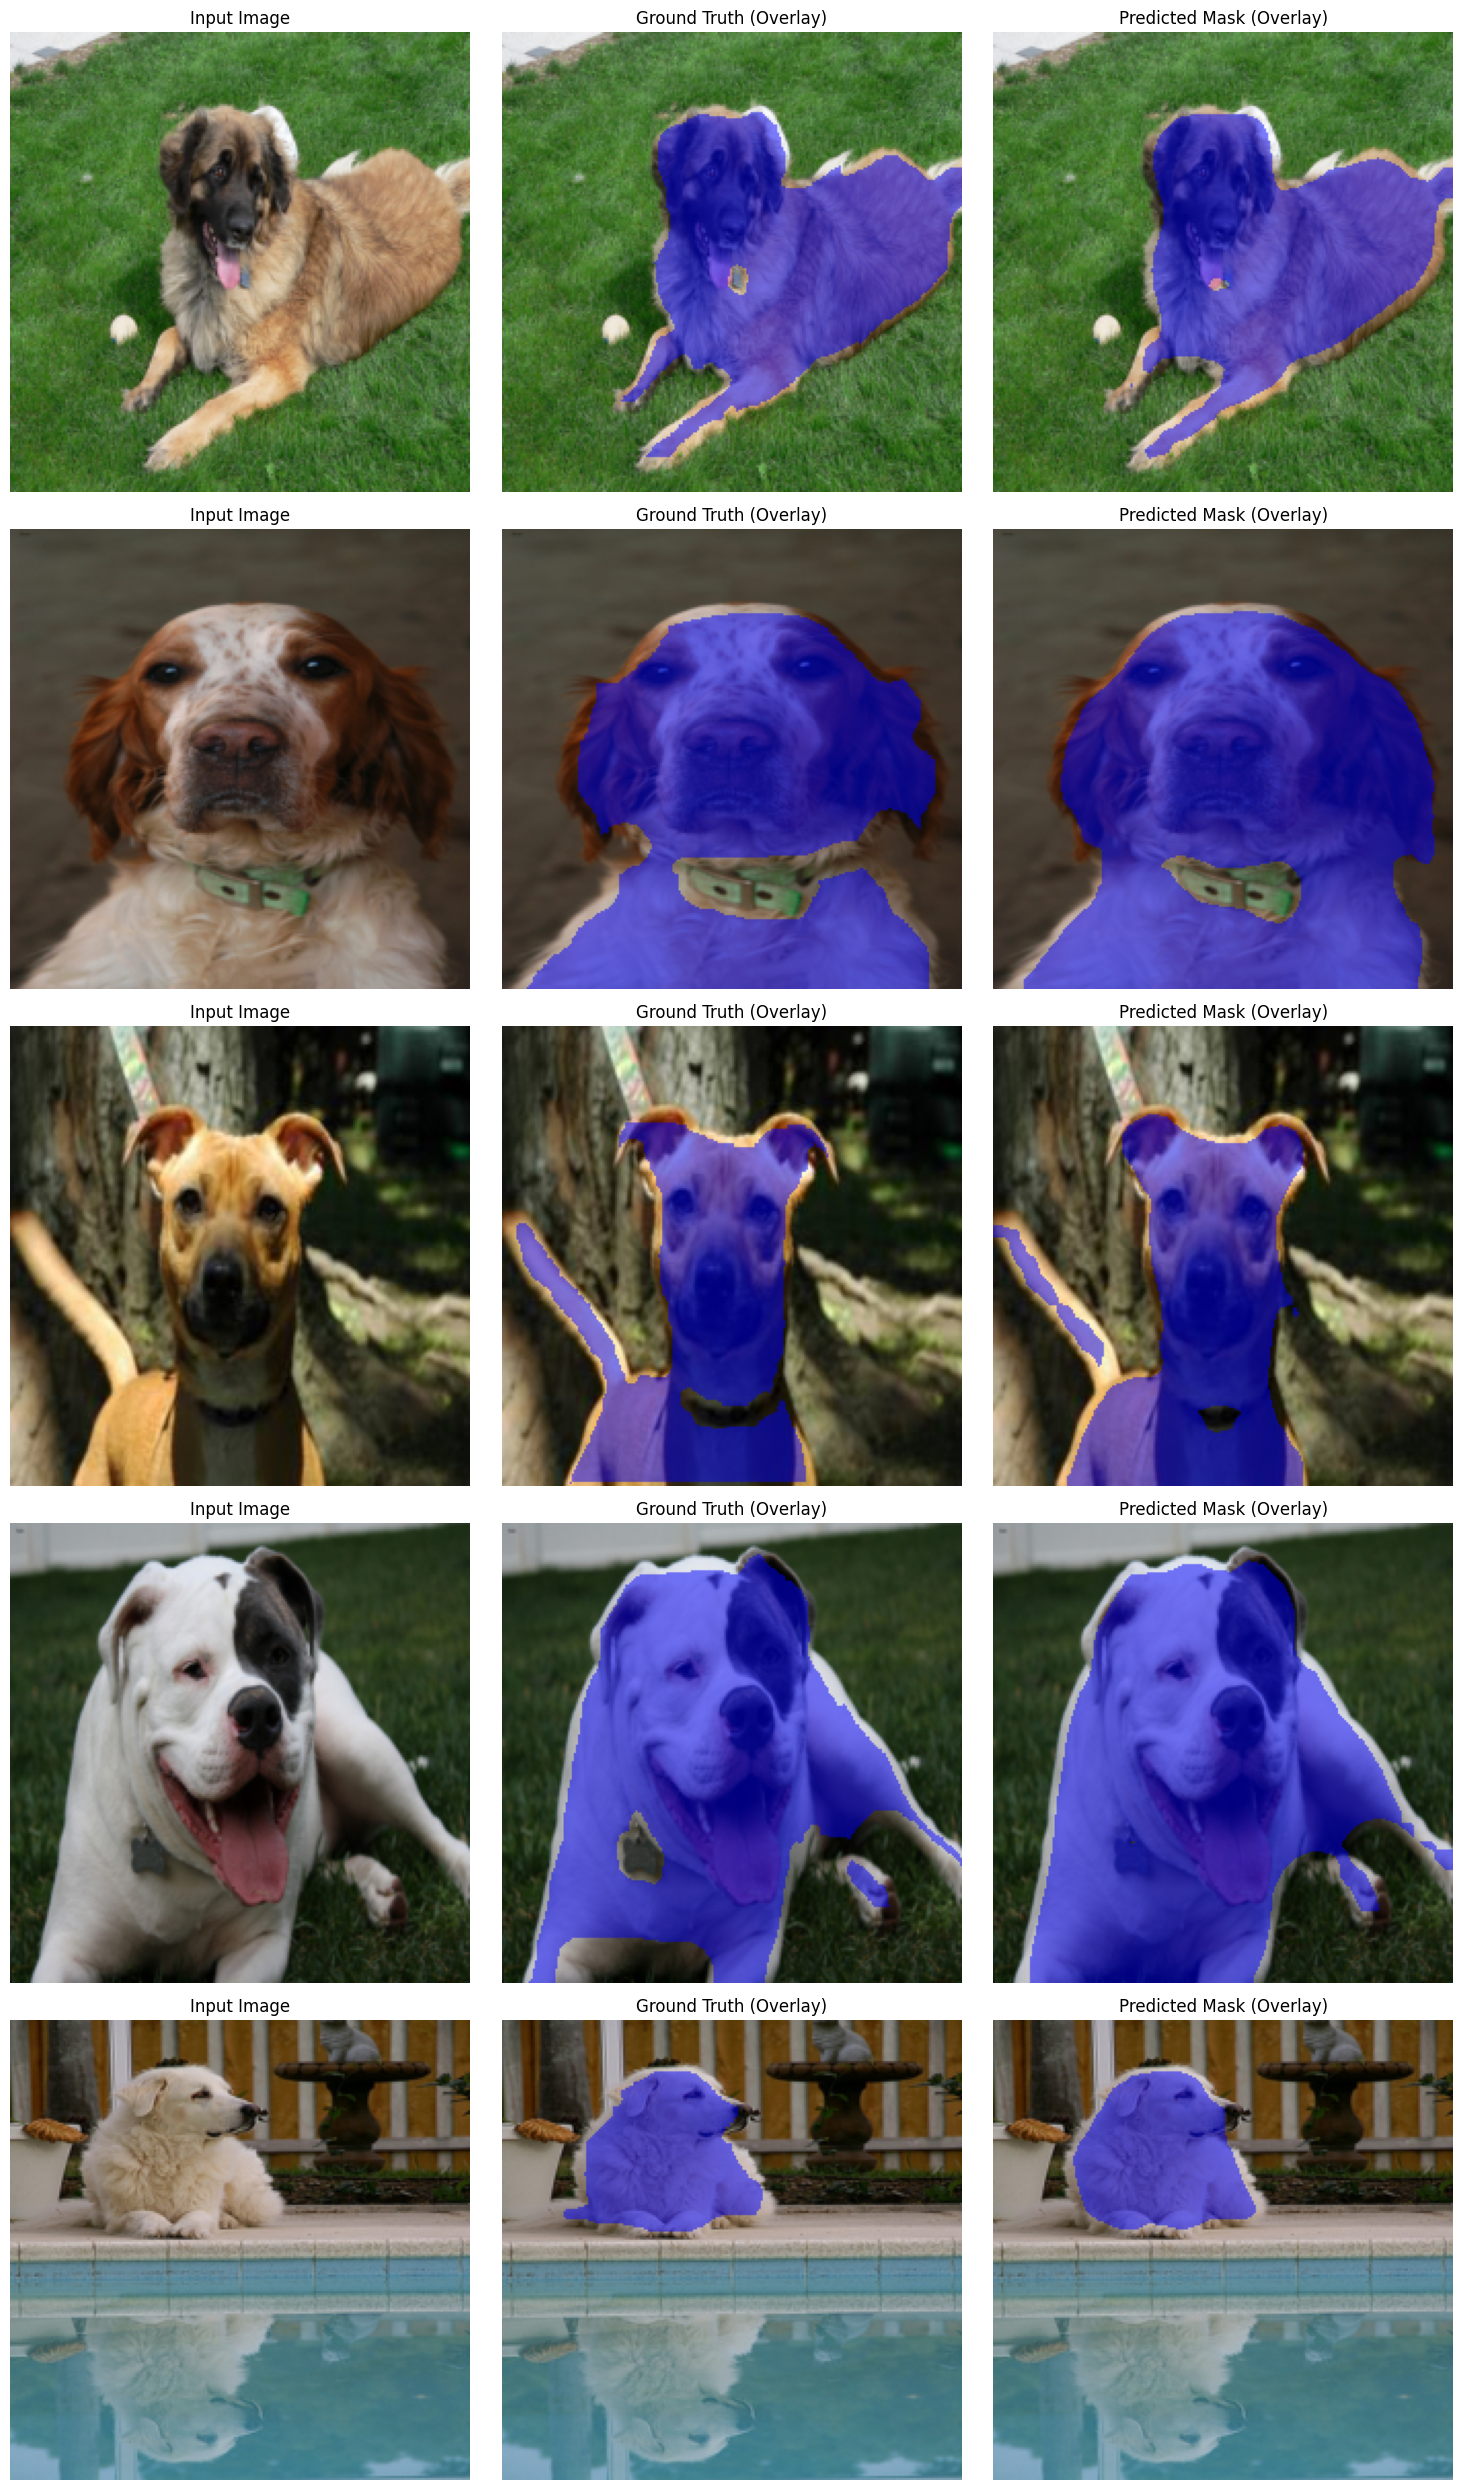

In [28]:
# Converts the mask to an RGB image using a predefined color map for visualization.
def decode_segmap(mask):
    # Define a color map for visualization (background will remain transparent)
    label_colors = np.array([
        (0, 0, 255),       # Pet - Blue
        (0, 0, 0),     # Background - Transparent (will remain unchanged)
        (0, 255, 0)      # Border - Green (if applicable)
    ])
    
    # Initialize r, g, b channels
    r = np.zeros_like(mask).astype(np.uint8)
    g = np.zeros_like(mask).astype(np.uint8)
    b = np.zeros_like(mask).astype(np.uint8)

    # Color the pet (label 1) and any other labels as needed
    for l in range(0, 2):  # Start from 1 to avoid coloring background (0)
        idx = mask == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb

# Helper function to overlay the mask on the original image
def overlay_mask_on_image(image, mask, alpha=0.5):
    """Overlay mask on image with transparency."""
    overlay = image.copy()
    mask_rgb = decode_segmap(mask)
    
    # Find mask where pet is present (non-background areas)
    mask_area = np.any(mask_rgb != 0, axis=-1)
    
    # Apply blending only where the pet is present, keep background unchanged
    overlay[mask_area] = alpha * mask_rgb[mask_area] / 255 + (1 - alpha) * image[mask_area]
    
    return np.clip(overlay, 0, 1)

# Visualize samples with the overlayed mask
def visualize_predictions(model, dataset, num_samples=5): 
    model.eval()
    indices = random.sample(range(len(dataset)), num_samples)
    fig, axs = plt.subplots(num_samples, 3, figsize=(15, num_samples * 5))
    for i, idx in enumerate(indices):
        img, mask = dataset[idx]
        img_input = img.unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(img_input)['out']
            pred = torch.argmax(output.squeeze(), dim=0).cpu().numpy()
        
        img_np = img.permute(1, 2, 0).numpy()
        img_np = img_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img_np = np.clip(img_np, 0, 1)
        mask_np = mask.numpy()
        pred_rgb = decode_segmap(pred)
        mask_rgb = decode_segmap(mask_np)
        
        # Create overlay images
        overlay_pred = overlay_mask_on_image(img_np, pred)
        overlay_gt = overlay_mask_on_image(img_np, mask_np)
        
        axs[i, 0].imshow(img_np)
        axs[i, 0].set_title('Input Image')
        axs[i, 0].axis('off')
        
        axs[i, 1].imshow(overlay_gt)
        axs[i, 1].set_title('Ground Truth (Overlay)')
        axs[i, 1].axis('off')
        
        axs[i, 2].imshow(overlay_pred)
        axs[i, 2].set_title('Predicted Mask (Overlay)')
        axs[i, 2].axis('off')
    plt.tight_layout()
    plt.show()

# Visualize predictions from the test dataset
visualize_predictions(model, test_dataset)


## 5. Export to ONNX format

[ONNX](https://onnx.ai/about.html) is an open format built to represent machine learning models and facilitate interoperability in the AI tools.  

In [29]:
import torch.onnx

# Define a dummy input matching the input shape of the model
dummy_input = torch.randn(1, 3, 224, 224, device=device)

# Specify the path where to save the ONNX model
onnx_model_path = "deeplabv3_pet_segmentation.onnx"

# Export the model

model.eval() 

# Export the model to ONNX format
torch.onnx.export(
    model,                         # Model being run
    dummy_input,                   # Model input (or a tuple for multiple inputs)
    onnx_model_path,               # Where to save the model
    opset_version=11,              # ONNX version to export the model to
    do_constant_folding=True,      # Whether to execute constant folding for optimization
    input_names=['input'],         # The model's input names
    output_names=['output'],       # The model's output names
    dynamic_axes={
        'input': {0: 'batch_size'},    # Variable length axes
        'output': {0: 'batch_size'}
    }
)

print(f"Model has been successfully exported to {onnx_model_path}")

Model has been successfully exported to deeplabv3_pet_segmentation.onnx


Visualize the model graph using Netron.

In [1]:
import netron
import threading
from IPython.display import IFrame
import time

# Specify the path to your ONNX model
onnx_model_path = "deeplabv3_pet_segmentation.onnx"

# Choose a port for Netron
netron_port = 8081  # Ensure this port is available

# Function to start Netron
def start_netron():
    netron.start(onnx_model_path, address=('localhost', netron_port), browse=False)

# Start Netron in a separate thread
threading.Thread(target=start_netron, daemon=True).start()

# Wait briefly to ensure the server is ready
time.sleep(1)

# Embed the Netron visualization
netron_url = f"http://localhost:{netron_port}"
IFrame(src=netron_url, width='100%', height='800px')

ModuleNotFoundError: No module named 'netron'